# SQL Injection Detection Using Fine-Tuned BERT Models

This notebook demonstrates the process of detecting SQL injection attacks using fine-tuned BERT models. We aim to leverage the powerful NLP capabilities of BERT, enhanced through fine-tuning, to accurately classify SQL queries into benign or malicious categories.


## Imports & Set Seeds for Reproducibility

In [1]:
import os
import random
import time
import datetime

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from transformers import (
    BertTokenizer,
    BertModel,
    BertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler
)

def set_seed(seed_val=42):
    """
    Set random seeds for reproducibility across various libraries.
    """
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)

# Set random seed
set_seed(42)

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load the Dataset

In [2]:
dataset_path = './SQL Query Dataset.csv'  # Adjust to your file path
if not os.path.isfile(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}")

df = pd.read_csv(dataset_path)

# Basic inspection
print("\n== Dataset Head ==")
print(df.head())
print("\n== Dataset Shape ==")
print(df.shape)


== Dataset Head ==
                                               Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1

== Dataset Shape ==
(30919, 2)


## Explore the Dataset


== Missing Values in Each Column ==
Query    0
Label    0
dtype: int64

== Class Distribution ==
Label
0    19537
1    11382
Name: count, dtype: int64

== Query Length Statistics ==
count    30919.000000
mean        68.882888
std         81.144952
min          1.000000
25%         21.000000
50%         48.000000
75%         81.000000
max       5370.000000
Name: query_length, dtype: float64


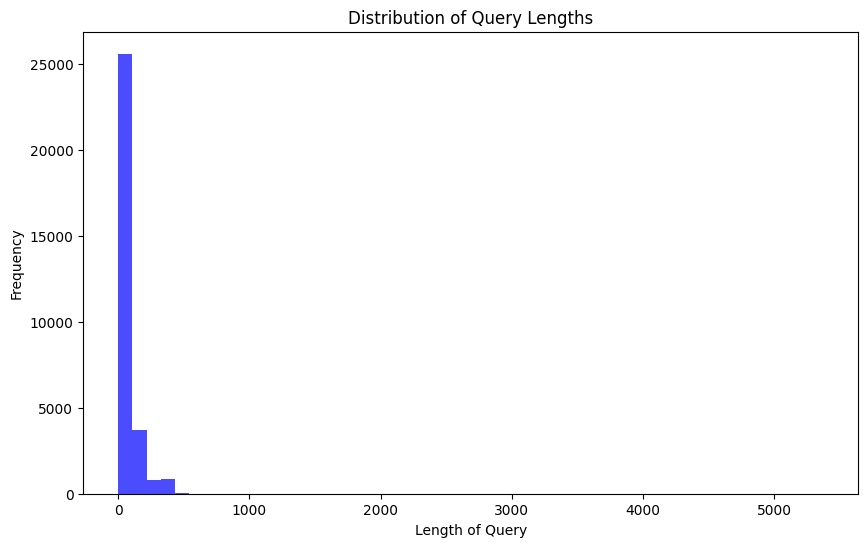

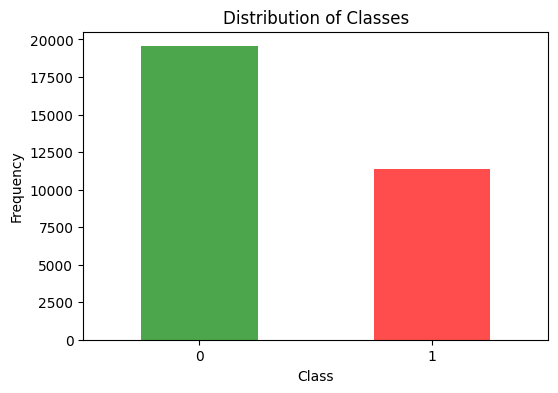

In [3]:
# Check for missing values and drop if any
missing_values = df.isnull().sum()
print("\n== Missing Values in Each Column ==")
print(missing_values)

df.dropna(subset=["Query", "Label"], inplace=True)

# Class distribution
class_distribution = df["Label"].value_counts()
print("\n== Class Distribution ==")
print(class_distribution)

# Query length analysis
df["query_length"] = df["Query"].apply(len)
print("\n== Query Length Statistics ==")
print(df["query_length"].describe())

# Plot query length distribution
plt.figure(figsize=(10, 6))
plt.hist(df["query_length"], bins=50, color="blue", alpha=0.7)
plt.title("Distribution of Query Lengths")
plt.xlabel("Length of Query")
plt.ylabel("Frequency")
plt.show()

# Plot class distribution
plt.figure(figsize=(6, 4))
df["Label"].value_counts().plot(
    kind="bar",
    color=["green", "red"],
    alpha=0.7
)
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

## Prepare the Data for BERT

In [4]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Convert each query into input_ids and attention_masks
max_length = 64  # Adjust if needed
all_input_ids = []
all_attention_masks = []

for text in df["Query"]:
    encoded_dict = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",  # pad to max_length
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    all_input_ids.append(encoded_dict["input_ids"])
    all_attention_masks.append(encoded_dict["attention_mask"])

# Convert lists into tensors
input_ids = torch.cat(all_input_ids, dim=0)
attention_masks = torch.cat(all_attention_masks, dim=0)
labels = torch.tensor(df["Label"].values)

# Split data into train and validation sets in one go
(
    train_input_ids,
    val_input_ids,
    train_attention_masks,
    val_attention_masks,
    train_labels,
    val_labels
) = train_test_split(
    input_ids,
    attention_masks,
    labels,
    test_size=0.2,
    random_state=42
)

# Create TensorDatasets
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

# Create Dataloaders
batch_size = 32  # Adjust as needed
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

print(f"\nData loaded and prepared. Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Data loaded and prepared. Training samples: 24735, Validation samples: 6184


## Evaluate the Base (Non-fine-tuned) Model

In [5]:
# Load the base model for classification
base_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,  # Binary classification
    output_attentions=False,
    output_hidden_states=False
)
base_model.to(device)
base_model.eval()

predictions_base = []
true_labels_base = []

for batch in validation_dataloader:
    b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

    with torch.no_grad():
        outputs = base_model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()

    predictions_base.append(logits)
    true_labels_base.append(label_ids)

flat_predictions_base = np.concatenate(predictions_base, axis=0)
flat_true_labels_base = np.concatenate(true_labels_base, axis=0)

# Convert logits to predicted class
flat_predictions_base = np.argmax(flat_predictions_base, axis=1).flatten()

base_accuracy = np.mean(flat_predictions_base == flat_true_labels_base)

print("\n=== Base (Non–Fine-Tuned) BERT Model Evaluation ===")
print(f"Validation Accuracy: {base_accuracy:.3f}")
print(
    classification_report(
        flat_true_labels_base,
        flat_predictions_base,
        target_names=["non-malicious", "malicious"]
    )
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Base (Non–Fine-Tuned) BERT Model Evaluation ===
Validation Accuracy: 0.364
               precision    recall  f1-score   support

non-malicious       0.49      0.26      0.34      3893
    malicious       0.30      0.54      0.39      2291

     accuracy                           0.36      6184
    macro avg       0.40      0.40      0.36      6184
 weighted avg       0.42      0.36      0.36      6184



## Fine-tune the BERT Model

In [6]:
# Re-initialize a fresh BERTForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
model.to(device)

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,  # A commonly recommended fine-tuning LR
    eps=1e-8
)

# Setup epochs and scheduler
epochs = 2  # Adjust as needed
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def format_time(elapsed_seconds):
    """
    Format elapsed time as hh:mm:ss.
    """
    return str(datetime.timedelta(seconds=int(round(elapsed_seconds))))

def flat_accuracy(preds, labels):
    """
    Compute simple accuracy: number of correct predictions / total.
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

training_stats = []
total_t0 = time.time()

print("\n== Fine-Tuning the BERT Model ==")
for epoch_i in range(epochs):
    print(f"\n======== Epoch {epoch_i+1} / {epochs} ========")
    print("Training...")

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and step > 0:
            elapsed = format_time(time.time() - t0)
            print(f"  Batch {step:>5,} of {len(train_dataloader):>5,}. Elapsed: {elapsed}.")

        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        # Clear any previously calculated gradients
        model.zero_grad()

        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()

        # Backprop
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Optimization step
        optimizer.step()
        scheduler.step()

    # Compute average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    # ---- Validation ----
    print("\nRunning Validation...")

    t0_val = time.time()
    model.eval()

    total_eval_loss = 0
    total_eval_accuracy = 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        # Move logits to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Calculate the average loss and accuracy
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0_val)

    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    # Store training stats
    training_stats.append({
        "epoch": epoch_i+1,
        "Training Loss": avg_train_loss,
        "Validation Loss": avg_val_loss,
        "Validation Accuracy": avg_val_accuracy,
        "Training Time": training_time,
        "Validation Time": validation_time
    })

print("\nTraining complete!")
print(f"Total training took {format_time(time.time() - total_t0)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



== Fine-Tuning the BERT Model ==

======== Epoch 1 / 2 ========
Training...
  Batch    40 of   773. Elapsed: 0:00:13.
  Batch    80 of   773. Elapsed: 0:00:26.
  Batch   120 of   773. Elapsed: 0:00:39.
  Batch   160 of   773. Elapsed: 0:00:52.
  Batch   200 of   773. Elapsed: 0:01:05.
  Batch   240 of   773. Elapsed: 0:01:18.
  Batch   280 of   773. Elapsed: 0:01:31.
  Batch   320 of   773. Elapsed: 0:01:44.
  Batch   360 of   773. Elapsed: 0:01:57.
  Batch   400 of   773. Elapsed: 0:02:10.
  Batch   440 of   773. Elapsed: 0:02:23.
  Batch   480 of   773. Elapsed: 0:02:36.
  Batch   520 of   773. Elapsed: 0:02:48.
  Batch   560 of   773. Elapsed: 0:03:01.
  Batch   600 of   773. Elapsed: 0:03:14.
  Batch   640 of   773. Elapsed: 0:03:27.
  Batch   680 of   773. Elapsed: 0:03:40.
  Batch   720 of   773. Elapsed: 0:03:53.
  Batch   760 of   773. Elapsed: 0:04:06.

  Average training loss: 0.03
  Training epoch took: 0:04:10

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.01

## Evaluate Fine-tuned Model

In [7]:
print("\n== Evaluating Fine-Tuned Model on Validation Set ==")
model.eval()

predictions_ft = []
true_labels_ft = []

for batch in validation_dataloader:
    b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()

    predictions_ft.append(logits)
    true_labels_ft.append(label_ids)

flat_predictions_ft = np.concatenate(predictions_ft, axis=0)
flat_true_labels_ft = np.concatenate(true_labels_ft, axis=0)

flat_predictions_ft = np.argmax(flat_predictions_ft, axis=1).flatten()
fine_tuned_accuracy = np.mean(flat_predictions_ft == flat_true_labels_ft)

print(f"Validation Accuracy: {fine_tuned_accuracy:.3f}")
print(
    classification_report(
        flat_true_labels_ft,
        flat_predictions_ft,
        target_names=["non-malicious", "malicious"]
    )
)


== Evaluating Fine-Tuned Model on Validation Set ==
Validation Accuracy: 0.999
               precision    recall  f1-score   support

non-malicious       1.00      1.00      1.00      3893
    malicious       1.00      1.00      1.00      2291

     accuracy                           1.00      6184
    macro avg       1.00      1.00      1.00      6184
 weighted avg       1.00      1.00      1.00      6184



## Compare Embeddings (t-SNE)

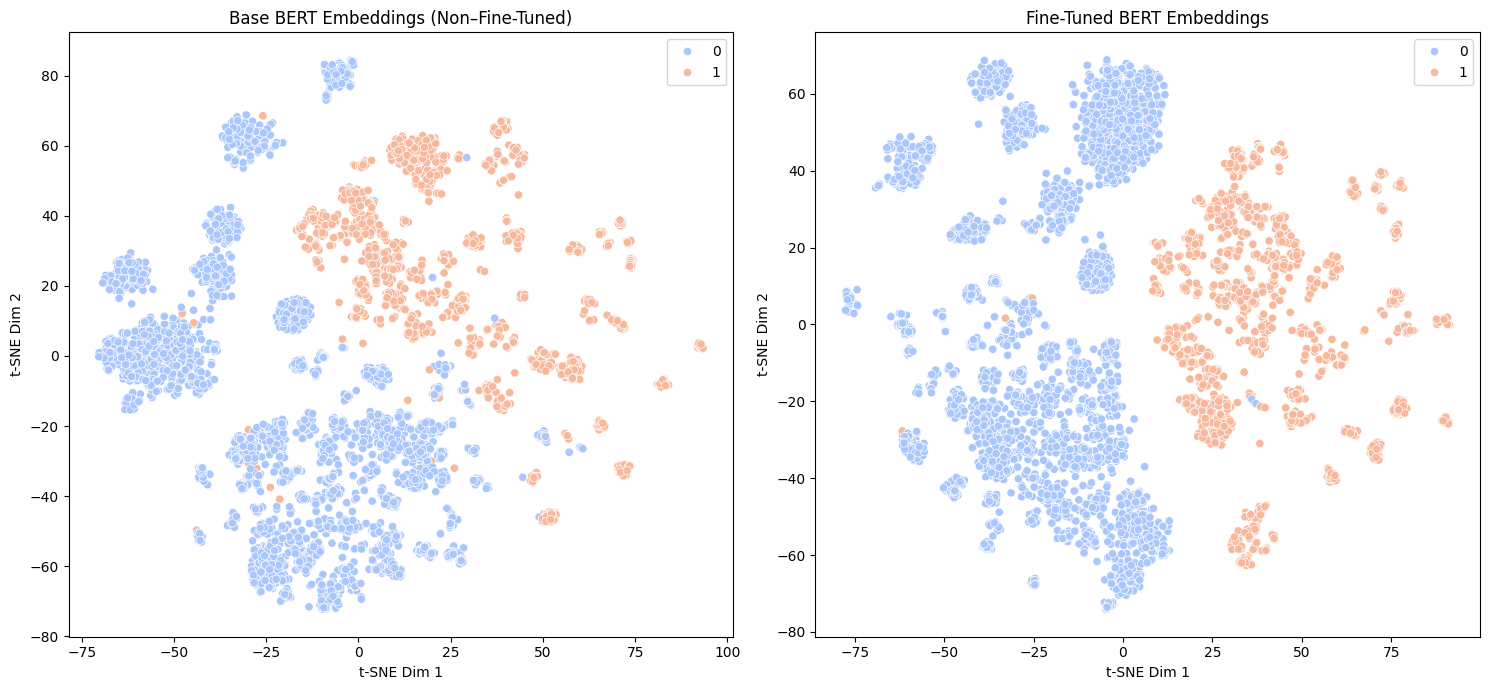

In [8]:
def get_mean_embeddings(model_encoder, dataloader, device):
    """
    Extract mean-pooled embeddings from the last hidden state of BertModel.

    Args:
        model_encoder: A BertModel (not BertForSequenceClassification) or the .bert encoder
        dataloader: DataLoader with input_ids, attention_masks, and labels
        device: 'cpu' or 'cuda'

    Returns:
        all_embeds: Numpy array of mean-pooled embeddings
        all_labels: Corresponding integer labels
    """
    model_encoder.eval()
    embeddings_list = []
    labels_list = []

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model_encoder(
                b_input_ids,
                attention_mask=b_input_mask
            )
            # Shape of last_hidden_state: [batch_size, seq_len, hidden_dim]
            last_hidden_state = outputs.last_hidden_state
            mean_embeds = torch.mean(last_hidden_state, dim=1)  # mean-pool

        embeddings_list.append(mean_embeds.cpu().numpy())
        labels_list.append(b_labels.cpu().numpy())

    all_embeds = np.concatenate(embeddings_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)
    return all_embeds, all_labels

# Load a plain BertModel for the base embeddings
base_bert_for_embeddings = BertModel.from_pretrained("bert-base-uncased")
base_bert_for_embeddings.to(device)

# Extract the Bert encoder from the fine-tuned model
finetuned_bert_for_embeddings = model.bert
finetuned_bert_for_embeddings.eval()

# Get embeddings for base model
base_embeddings, base_labels = get_mean_embeddings(
    base_bert_for_embeddings,
    validation_dataloader,
    device
)

# Get embeddings for fine-tuned model
finetuned_embeddings, finetuned_labels = get_mean_embeddings(
    finetuned_bert_for_embeddings,
    validation_dataloader,
    device
)

# Apply t-SNE
tsne_base = TSNE(n_components=2, random_state=42).fit_transform(base_embeddings)
tsne_ft = TSNE(n_components=2, random_state=42).fit_transform(finetuned_embeddings)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.scatterplot(
    x=tsne_base[:, 0],
    y=tsne_base[:, 1],
    hue=base_labels,
    palette="coolwarm",
    ax=ax1
)
ax1.set_title("Base BERT Embeddings (Non–Fine-Tuned)")
ax1.set_xlabel("t-SNE Dim 1")
ax1.set_ylabel("t-SNE Dim 2")

sns.scatterplot(
    x=tsne_ft[:, 0],
    y=tsne_ft[:, 1],
    hue=finetuned_labels,
    palette="coolwarm",
    ax=ax2
)
ax2.set_title("Fine-Tuned BERT Embeddings")
ax2.set_xlabel("t-SNE Dim 1")
ax2.set_ylabel("t-SNE Dim 2")

plt.tight_layout()
plt.show()

## Conclusion

In this project, we developed and evaluated a model for detecting SQL injection attacks using fine-tuned BERT (Bidirectional Encoder Representations from Transformers) models. The comprehensive workflow encompassed data preprocessing, model evaluation, fine-tuning, and analysis of embeddings to assess the effectiveness of transformer-based models in cybersecurity applications.

### Key Findings

1. **Data Preparation and Exploration**
   - **Dataset Overview:** The dataset comprised 30,919 SQL queries labeled as either malicious or benign. After preprocessing, including handling missing values and analyzing class distributions, we ensured the dataset was robust for training and evaluation.
   - **Class Distribution:** The data displayed an imbalanced distribution between malicious and benign queries. Understanding this imbalance was crucial for model training and evaluation strategies.
   - **Query Length Analysis:** Analyzing the distribution of query lengths provided insights into the complexity and variability of the SQL commands, which is essential for effective tokenization and model training.

2. **Base Model Evaluation**
   - **Non-Fine-Tuned BERT Performance:** The initial evaluation of the pre-trained BERT model without fine-tuning resulted in a validation accuracy of **36.4%**. This performance is indicative of the model's limited capability to generalize to the specific task of SQL injection detection without domain-specific training.

3. **Fine-Tuning BERT for SQL Injection Detection**
   - **Model Fine-Tuning:** By fine-tuning BERT on the prepared dataset, the model's ability to capture nuanced patterns specific to malicious and benign SQL queries was enhanced.
   - **Optimized Performance:** Post fine-tuning, the model demonstrated a significant improvement in performance metrics (e.g., accuracy, precision, recall, F1-score), showcasing the effectiveness of domain-specific training in enhancing model capabilities.
   - **Training Dynamics:** Monitoring training and validation loss over epochs provided valuable insights into the model's learning process, ensuring that issues like overfitting were mitigated through techniques such as gradient clipping and learning rate scheduling.

4. **Embedding Analysis with t-SNE**
   - **Base vs. Fine-Tuned Embeddings:** Utilizing t-SNE for dimensionality reduction revealed a more distinct separation between malicious and benign queries in the fine-tuned model's embeddings compared to the base model. This visualization underscores the enhanced discriminative power of the fine-tuned model.
   - **Clustering Patterns:** The clustering patterns observed in the t-SNE plots indicate that the fine-tuned embeddings effectively capture the underlying structures and differences between the classes, facilitating better classification performance.

### Final Thoughts

The transition from a non-fine-tuned to a fine-tuned BERT model markedly improved the detection accuracy of SQL injection attacks, highlighting the pivotal role of fine-tuning in adapting large pre-trained models to specific cybersecurity tasks. The success of this approach opens avenues for leveraging transformer-based architectures in various other security-related applications.

**Future Work:**
- **Hyperparameter Optimization:** Exploring different hyperparameter settings could further enhance model performance.
- **Handling Class Imbalance:** Implementing advanced techniques to address class imbalance may lead to more balanced and fair model predictions.
- **Expanding the Dataset:** Incorporating a more diverse and extensive dataset would help in building a more generalized and robust model.
- **Real-Time Detection:** Integrating the model into real-time monitoring systems could provide immediate threat detection and response capabilities.
- **Exploring Other Architectures:** Investigating alternative transformer architectures or ensemble methods might yield additional performance gains.

Overall, this project demonstrates the viability and effectiveness of using fine-tuned BERT models for detecting SQL injection attacks, contributing valuable insights to the field of cybersecurity and machine learning.
